# Lectura formato CSV

En este notebook, se explicará un ejemplo de lectura de información de paciente en formato CSV.

Para ello, se hará uso de la clase Paciente, y se expondrá la totalidad de la funcionalidad disponible en dicha clase, para un único paciente.

In [1]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from copy import deepcopy
import utils
import patient_manager
from paciente import Paciente
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 
plt.rcParams["patch.force_edgecolor"] = True
%load_ext autoreload
%autoreload 2

## Configuración de variables

En esta sección, se indica el paciente que se desea analizar, así como las variables que se van a estudiar.

In [2]:
# Indicar la ruta donde se encuentra el fichero que se va a estudiar
dataset_dir = "../data/pacientes/"
nombre_fichero = "data_5.csv"

# Directorio donde se va a almacenar la información del paciente serializada
pickle_dir = os.path.join(dataset_dir, "pickle")

# Indicamos las variables que vamos a querer estudiar. Tienen que ser variables que se encuentren disponibles en el fichero csv
variables_significativas = ['Abdomen','Activity', 'Audio Volume dB', 'Flow', 'Presion Nasal', 'Pulso','SpO2','Snore']

# Establece tamaño de texto para los gráficos
utils.set_font_size(plt, size=14)

## Lectura paciente

A continuación, se realiza la lectura del paciente, y se hace uso de toda la funcionalidad integrada en el mismo.

In [3]:
# Inicializar paciente
paciente = Paciente(filename=os.path.join(dataset_dir, nombre_fichero), variables_significativas=variables_significativas)

if paciente.comprobar_validez_dataset(): # Compruebo que el dataset sea válido
    paciente.calcular_indices_paciente() # Calculo indices de apnea, hipopnea y apnea-hipopnea del paciente
    paciente.compute_correlation_matrix() # Calculo la matriz de correlacion

    # Calculo el retraso de las señales del paciente
    for signal in tqdm(paciente.variables_significativas):
        paciente.compute_sincronizacion_señales(main_signal=signal, seconds_prior = 60, seconds_post = 10)

    # Si se desea almacenar el paciente, se puede hacer con la siguiente linea
    # paciente.almacenar_paciente()

100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


In [4]:
print(paciente)

Paciente del fichero: ../data/pacientes/data_5.csv

Índices paciente:
	Índice Apnea: 51.71
	Índice Hypopnea: 78.85
	Índice Apnea-hypopnea: 130.56



In [5]:
paciente.df

,time_stamp,time_stamp_original,activity,audio_volume_db,presion_nasal,pulso,abdomen,spo2,flow,snore,apnea_mixed,apnea_central,apnea_obstructive,hypopnea_central,hypopnea_obstructive,hypopnea
0,00:00:00.000,23:46:22.000,0.024210,43.82,-1.12600,78,0.000019,88,0.77010,-0.001000,0,0,0,0,0,0
1,00:00:00.333,23:46:22.333,0.008647,46.87,-0.68710,78,0.000030,88,0.50530,0.001543,0,0,0,0,0,0
2,00:00:00.666,23:46:22.666,0.010380,44.77,0.55290,78,0.000027,88,-0.33050,-0.002717,0,0,0,0,0,0
3,00:00:00.999,23:46:22.999,0.008545,46.71,0.91960,78,0.000004,88,-0.50940,0.001549,0,0,0,0,0,0
4,00:00:01.332,23:46:23.332,0.014340,46.19,0.64540,78,-0.000010,88,-0.39950,-0.000988,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67314,06:13:35.562,05:59:57.562,0.028480,46.63,0.07005,76,0.000028,79,-0.06992,0.000220,0,0,0,0,0,1
67315,06:13:35.895,05:59:57.895,0.028890,46.59,0.06784,77,0.000027,79,-0.06797,-0.000763,0,0,0,0,0,1
67316,06:13:36.228,05:59:58.228,0.051270,72.37,0.10200,77,0.000024,79,-0.10220,0.000405,0,0,0,0,0,1
67317,06:13:36.561,05:59:58.561,0.034690,79.92,0.23960,77,0.000015,79,-0.20710,0.002497,0,0,0,0,0,1


## Correlacion variables

A continuación, se muestra la correlación existente entre las variables

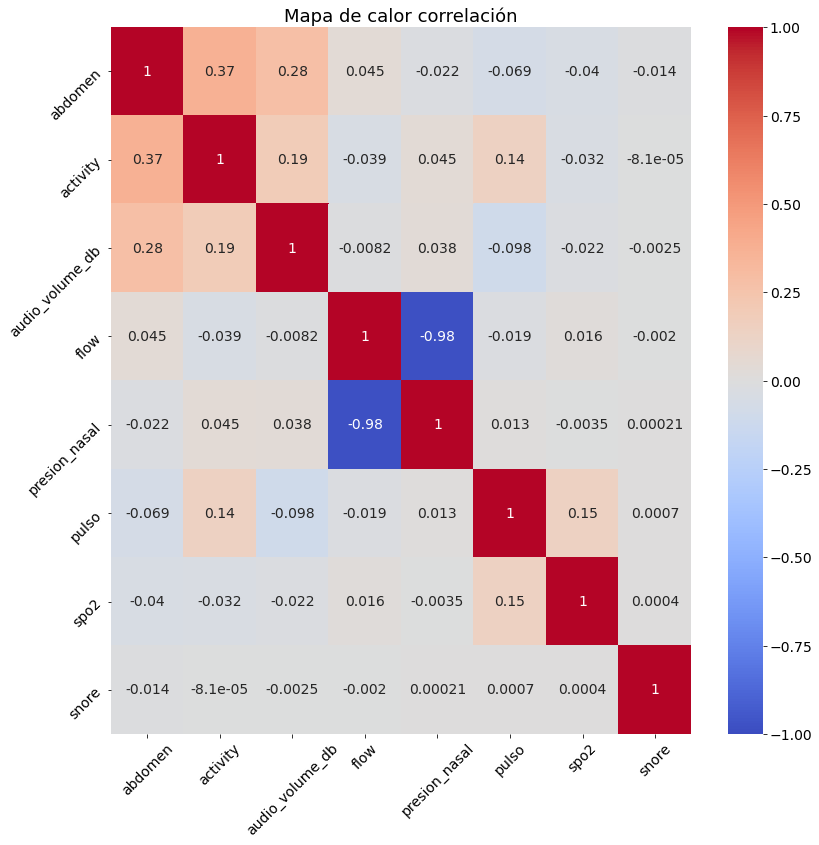

In [6]:
# Calculamos la matriz de correlacion
paciente.compute_correlation_matrix(plot_results = True)

## Estudio episodios de apnea

Se analiza el comportamiento de las señales en un determinado episodio de apnea. Observamos gráficamente el comportamiento de las señales

In [7]:
def plot_tramo(df, inicio_tramo, fin_tramo, step, variables_significativas, segundos_previos = 10, segundos_posteriores = 10, original_timestamps=False):
    time_stamp = "time_stamp_original" if original_timestamps else "time_stamp"

    # Calculamos cuantos puntos necesitamos
    previous_points, post_points = int(segundos_previos/step), int(segundos_posteriores/step)

    df_actual = df.iloc[range(inicio_tramo_actual-previous_points, fin_tramo_actual+post_points)]

    # Obtenemos los puntos que vamos a representar en el eje horizontal
    x = df_actual[time_stamp]

    # Establecemos cuantos ticks queremos mostrar en el eje horizontal
    number_ticks = 4

    x_l = list(x)
    x_ticks = [x_l[i] for i in range(0, len(x), int((len(x_l))/(number_ticks)))]

    for variable in variables_significativas:
        y = df_actual[variable]
        plt.figure(figsize=(10, 5))
        plt.plot(x,y, label=variable)

        # Mostramos las lineas de comienzo y fin de la apnea
        plt.axvline(df_actual[time_stamp][inicio_tramo_actual], linestyle='--', label="Inicio apnea", color="C1")
        plt.axvline(df_actual[time_stamp][fin_tramo_actual], linestyle='--', label="Fin apnea", color="C1")

        plt.legend()

        # Ajustamos las marcas temporales del gráfico
        plt.xticks(x_ticks)
        
        xlabel = "Hora (hh:mm:ss) en la que sucede el evento" if original_timestamps else "Tiempo (hh:mm:ss) desde inicio prueba" 
        plt.xlabel(xlabel)

        plt.show()

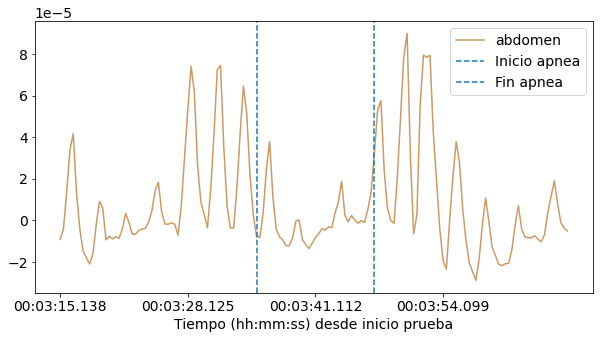

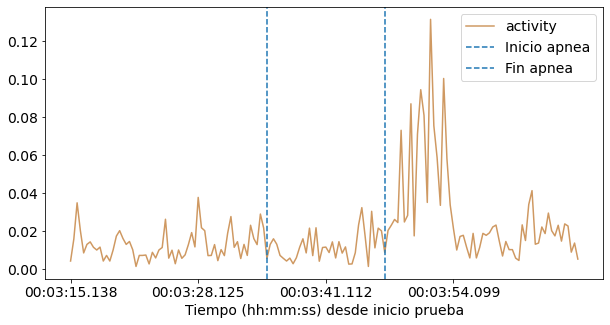

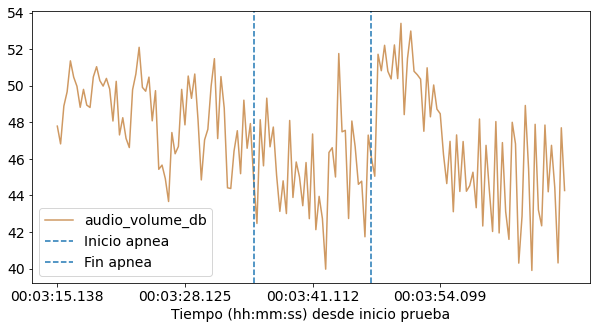

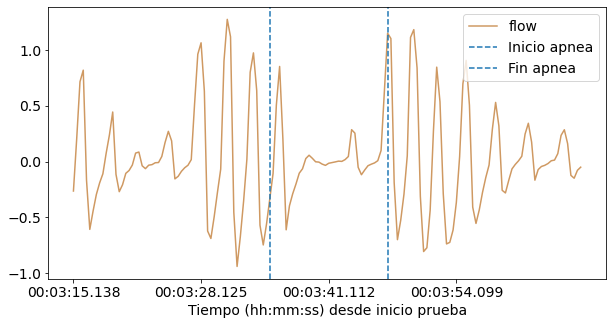

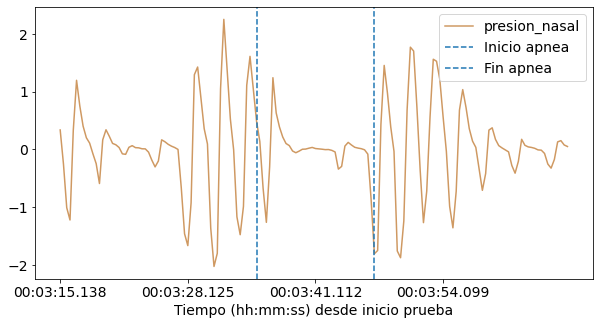

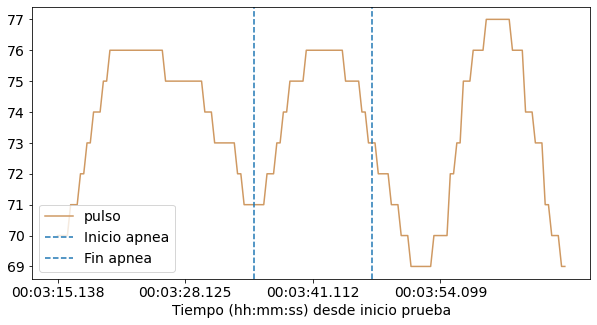

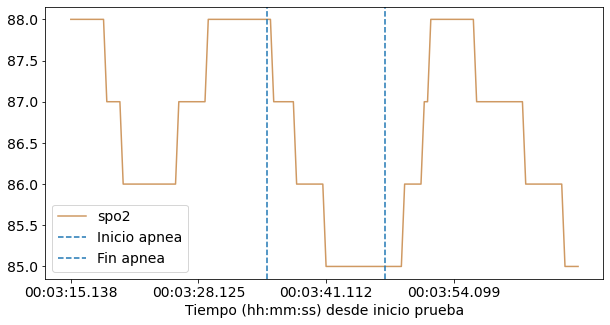

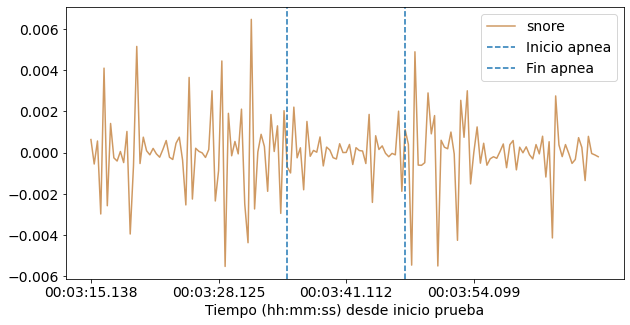

In [8]:
# Obtenemos el inicio y el fin del tramo que vamos a representar gráficamente
tramos_apnea = patient_manager.obtener_tramos_activos(paciente.df, ["apnea_obstructive"])

inicio_tramo_actual, fin_tramo_actual = tramos_apnea[0]
plot_tramo(paciente.df, inicio_tramo_actual, fin_tramo_actual, variables_significativas=paciente.variables_significativas, step=paciente.time_step, segundos_previos = 20, segundos_posteriores = 20)

A partir de estas gráficas, podemos extraer múltiples hipótesis. Sin embargo, cabe destacar que estamos observando únicamente 1 evento de apnea, y puede que estas hipótesis no generalicen de forma correcta al resto de eventos. Podemos extraer las siguientes conclusiones:
 - Durante la apnea obstructiva, el movimiento del abdomen se reduce significativamente.
 - Durante el periodo posterior a la apnea, suele haber más actividad.
 - El flujo de aire se ve interrumpido durante el periodo de apnea.
 - Hay un incremento en la frecuencia cardiaca del paciente.
 - Se reduce el sonido del ronquido durante el periodo de apnea.

## Estudio retraso señales

En esta sección, se analizará cómo se puede estudiar el retraso de una señal frente a otra. Para ello, haciendo uso de la clase Paciente, se mostrará gráficamente como al desplazar una de las señales hacia delante o hacia atrás, varía la correlación.

Se va a analizar el adelanto de las señales de forma global, durante la duración de toda la prueba.

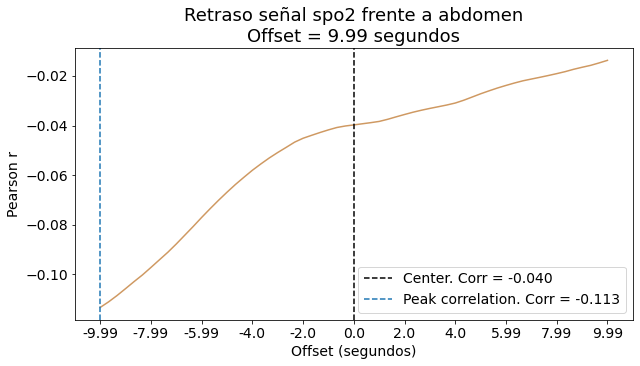

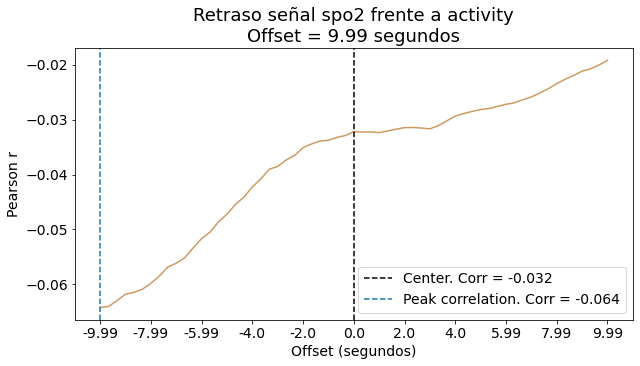

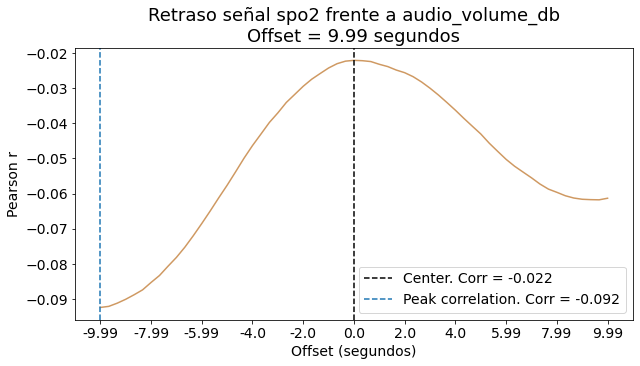

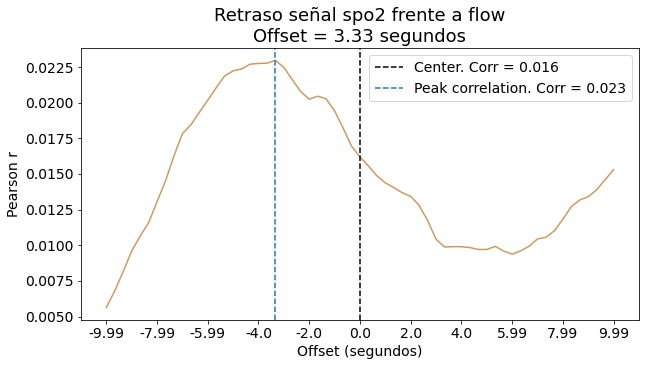

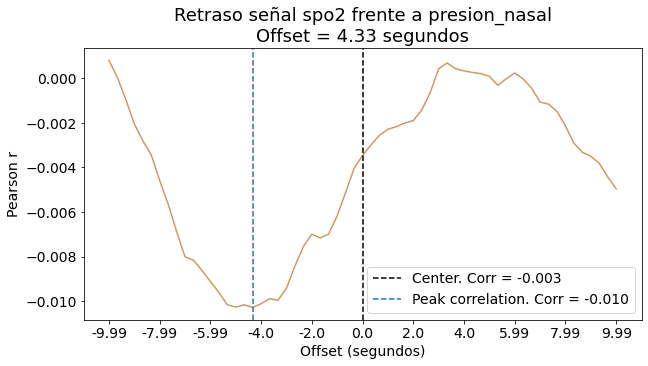

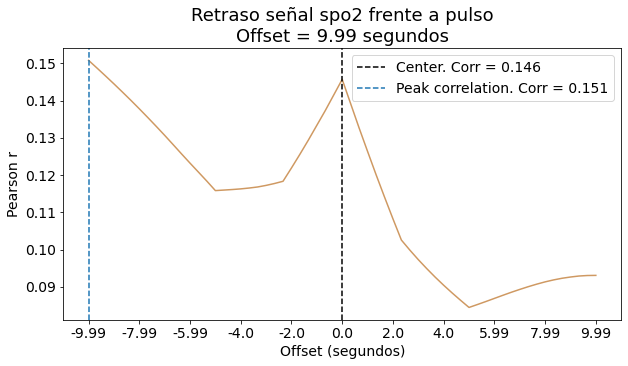

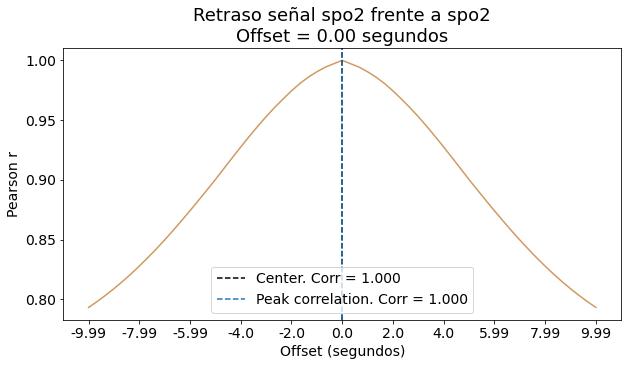

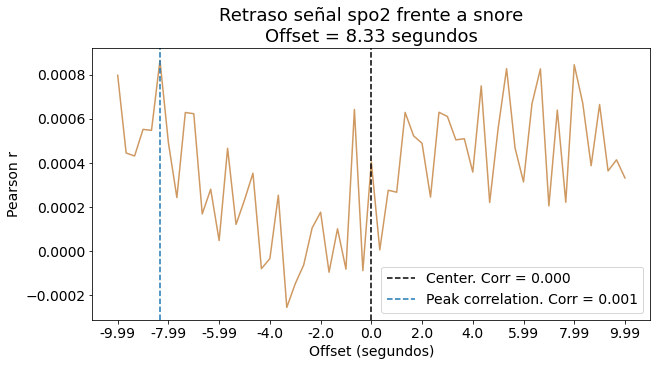

In [9]:
paciente.compute_sincronizacion_señales(main_signal="spo2", seconds_prior = 10, seconds_post = 10, plot_results=True)

En las gráficas estamos representando con qué desplazamiento temporal de la serie se obtiene un coeficiente de relación mayor (en valor absoluto) frente a la saturación.